# MLFlow for Kaggle II - Loan Approval Prediction

In this notebook we will use the Loan Approval dataset to demonstrate how to build a machine learning pipeline using the MLFlow library. We will use the following steps:

1. Data Collection
2. Data Exploration
3. EDA - Exploratory Data Analysis
4. Data Preprocessing
5. Model Selection
6. Model Training
7. Model Evaluation
8. Model Optimization
9. Model Tracking
10. Kaggle Submission


## 1. Data Collection

### Loan Approval Prediction

Go to the [Loan Approval Prediction Competition](https://www.kaggle.com/competitions/playground-series-s4e10/overview). **Join the competition** and accept the terms and conditions.

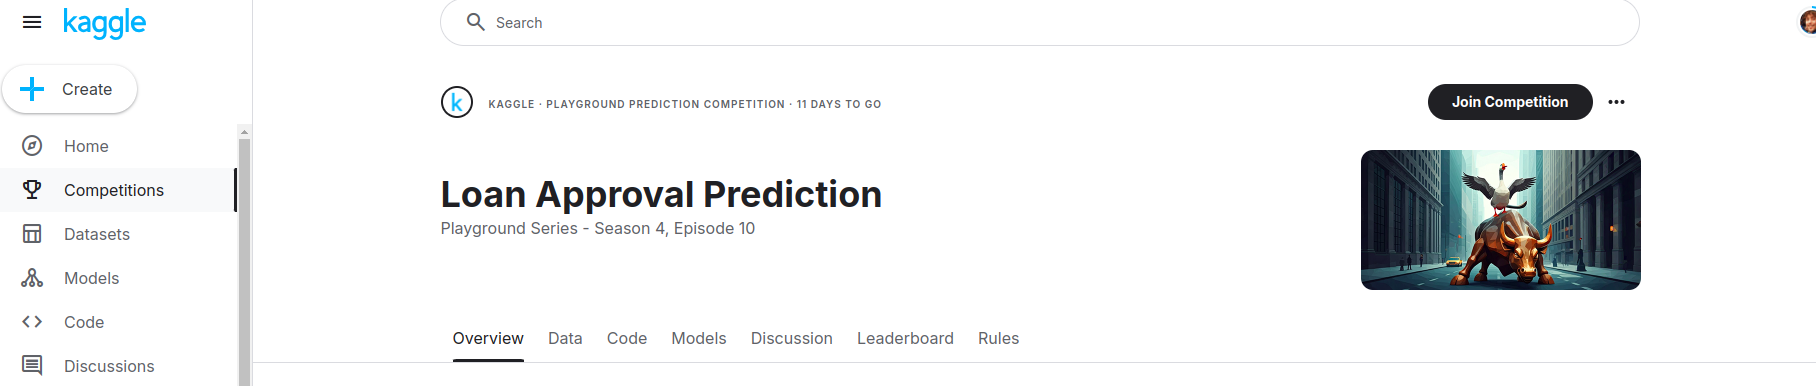

Now **download the data manually** by going to `Data` > `Download Data`

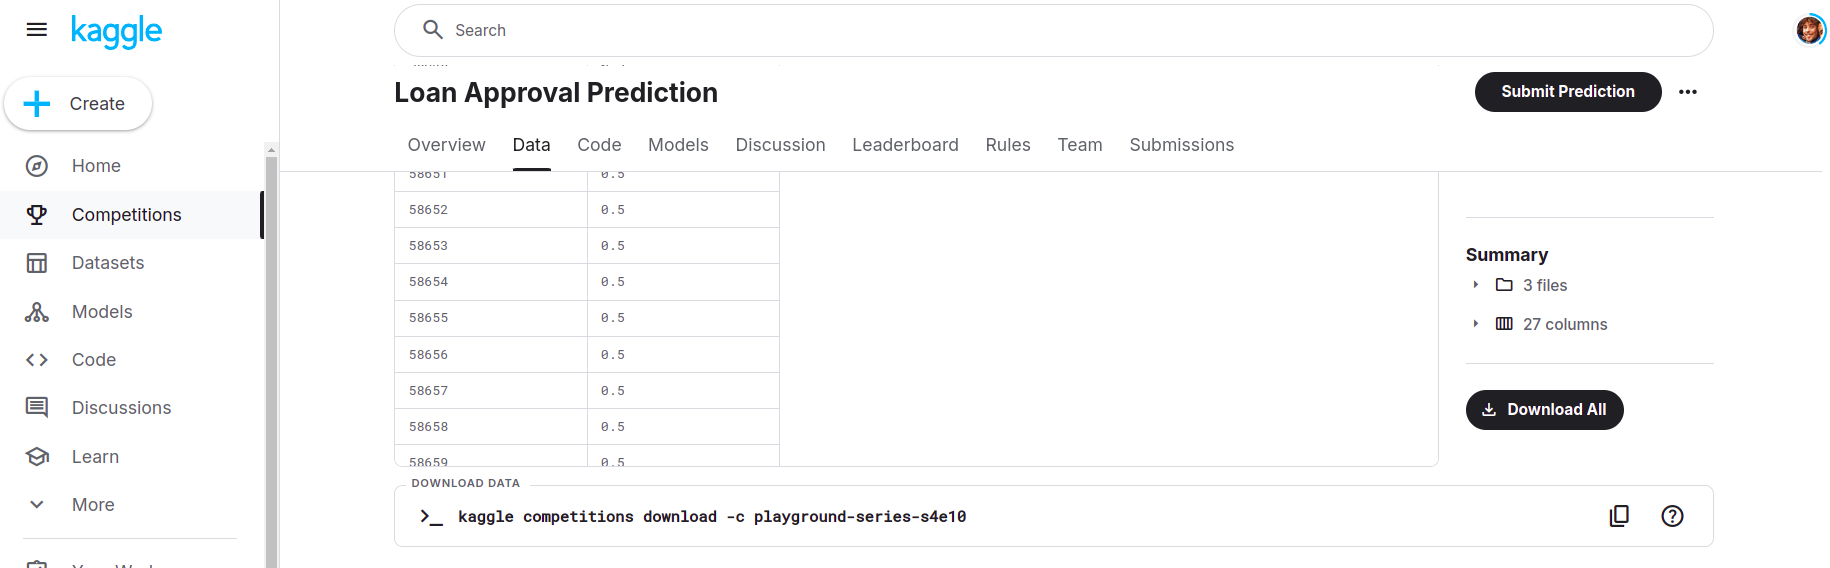

Once we've downloaded the data we are going to save it into `data/loan_prediciton`. We can see there are three files:

- `train.csv`: The training data
- `test.csv`: The test data
- `sample_submission.csv`: The sample submission file

ℹ️ Remember that `test.csv` does not have the target column, we will use it to evaluate our model against the kaggle platform.

## 2. Data Exploration

Let's load the data and take a look at the first few rows.

In [1]:
import pandas as pd

### Paths

In [2]:
DATA_FOLDER = "./data/loan_prediction/"
TRAIN_CSV_PATH = DATA_FOLDER + "train.csv"
TEST_CSV_PATH = DATA_FOLDER + "test.csv"
SUBMISSION_CSV_PATH = DATA_FOLDER + 'submission.csv'

### Load of datasets

In [3]:
train_df = pd.read_csv(TRAIN_CSV_PATH, index_col='id')
test_df = pd.read_csv(TEST_CSV_PATH, index_col='id')

train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


**Feature Descriptions**

- person_age: Applicant’s age in years.
- person_income: Annual income of the applicant in USD.
- person_home_ownership: Status of homeownership (e.g., Rent, Own, Mortgage).
- person_emp_length: Length of employment in years.
- loan_intent: Purpose of the loan (e.g., Education, Medical, Personal).
- loan_grade: Risk grade assigned to the loan, assessing the applicant’s creditworthiness.
- loan_amnt: Total loan amount requested by the applicant.
- loan_int_rate: Interest rate associated with the loan.
- loan_percent_income: Percentage of the applicant’s income allocated towards loan repayment.
- cb_person_default_on_file: Indicates if the applicant has a history of default ('Y' for yes, 'N' for no).
- cb_person_cred_hist_length: Length of the applicant’s credit history in years.
- loan_status: The approval status of the loan (1 for rejected, 0 for approved).

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


## 3. EDA - Exploratory Data Analysis

Let's dive into the data and understand it better. In order to do so we import the plotting libraries.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt




We will look at the following:

- Distribution of the loan amount


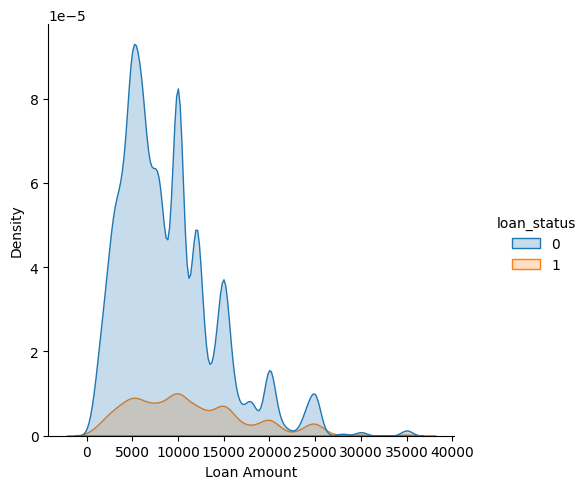

In [6]:
ax = sns.displot(train_df, x='loan_amnt', hue='loan_status', kind='kde', fill=True)
ax.set_axis_labels('Loan Amount', 'Density')
plt.show()

- Distribution of the applicant income

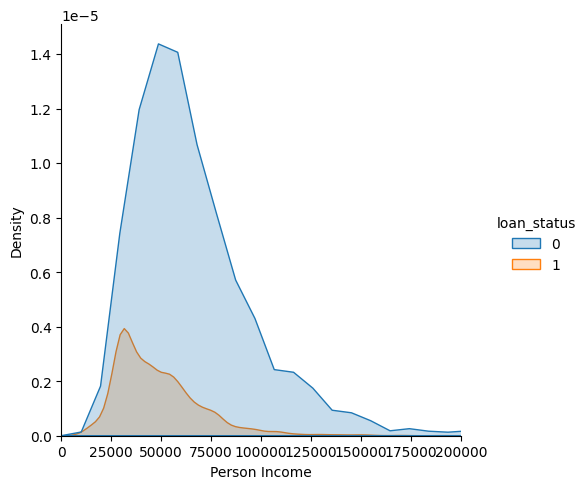

In [7]:
ax = sns.displot(train_df, x='person_income', hue='loan_status', kind='kde', fill=True)
ax.set(xlim=(0, 200000))
ax.set_axis_labels('Person Income')
plt.show()

- person income vs loan amount

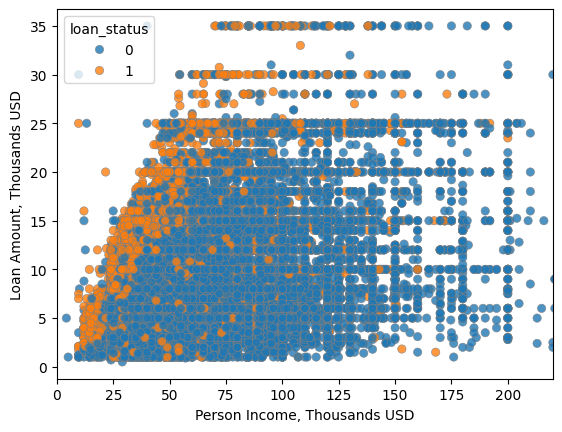

In [8]:
ax = sns.scatterplot(data=train_df, x=train_df.person_income * 1E-3, y=train_df.loan_amnt * 1E-3,
                     hue='loan_status', alpha=0.8, edgecolor='gray')
ax.set(xlim=(0, 220))
ax.set_xlabel('Person Income, Thousands USD')
ax.set_ylabel('Loan Amount, Thousands USD')
plt.show()

- Loan Percent Income

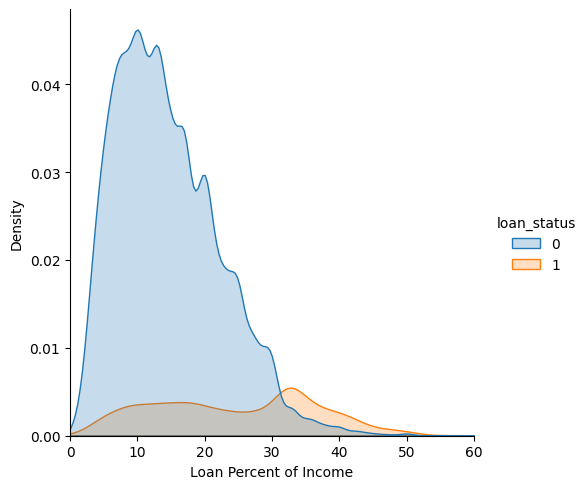

In [9]:
ax = sns.displot(train_df, x=train_df.loan_percent_income * 100, hue='loan_status', kind='kde', fill=True)
ax.set(xlim=(0,60))
ax.set_axis_labels('Loan Percent of Income')
plt.show()

## 4. Data Preprocessing

Remember that we need to preprocess the data before training the model. We will do the following steps:

- Encode the categorical columns
- Scale the numerical columns


### Get the numerical and categorical features lists

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
num_features = list( train_df.select_dtypes('number').columns )
num_features.remove('loan_status')

cat_features = list( train_df.select_dtypes('object').columns )

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features),
    ]
)

## 5. Split train and test

Split the data into train and validation sets.

In [13]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42

X = train_df.drop(columns=['loan_status'])
y = train_df['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 6. Model Tracking

Once we have trained the model we can use the MLFlow library to track the model performance. We can log the AUC, the metrics, the submission file...

### Connect to MLFlow

In [14]:
import mlflow

In [15]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("kaggle_loan_prediction")

2025/01/17 23:20:03 INFO mlflow.tracking.fluent: Experiment with name 'kaggle_loan_prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/429015150349487003', creation_time=1737152403504, experiment_id='429015150349487003', last_update_time=1737152403504, lifecycle_stage='active', name='kaggle_loan_prediction', tags={}>

## 7. Models Training

### Import the models

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### Store models in dictionary
Store the models in a dictionary to keep better track of them.

In [17]:
model_names = ['LogisticRegression',
               'SVC',
               'DecisionTreeClassifier',
               'GradientBoostingClassifier',
               'AdaBoostClassifier',
               'KNeighborsClassifier',
               #'XGBClassifier',
               'LGBMClassifier']

model_objects = [LogisticRegression(random_state=RANDOM_STATE),
                 SVC(),
                 DecisionTreeClassifier(random_state=RANDOM_STATE),
                 GradientBoostingClassifier(random_state = RANDOM_STATE),
                 AdaBoostClassifier(random_state = RANDOM_STATE),
                 KNeighborsClassifier(),
                 #XGBClassifier(random_state = RANDOM_STATE),
                 LGBMClassifier(random_state = RANDOM_STATE, verbosity=-1)
                 ]

# create dictionary to store models and their attributes
models = {k:{} for k in model_names}
# for each model name, create the model object
for dic, model in zip(models.values(), model_objects):
    dic['model'] = model

### Create a pipeline to preprocess data

We are going to create a **Pipeline**. This drastically simplifies the process of building a machine learning model because it bundles the preprocessing and the model into a single object.

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
def create_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model),
    ])
    return pipeline

### Train the models

In [20]:
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature

In [21]:
def train_log_model(model_name):

    print(f'Training model: {model_name}')
    
    # retrieve the model
    model = models[model_name]['model']

    # use the pipeline for each different model
    pipeline = create_pipeline(model) 

    # Create a new run for each model
    with mlflow.start_run(run_name=model_name):

        try:
            # Train the model
            model = pipeline.fit(X_train, y_train)
            
            # make predictions
            y_val_pred = model.predict(X_val)
            auc = roc_auc_score(y_val, y_val_pred)
        except Exception as e:
            print(f'\nError when training model {model_name}')
            print(e)
            return
                
        # Log model-specific parameters and metrics
        mlflow.log_param("model_type", model_name)
        mlflow.log_metric("auc", auc)
        
        # Infer the signature of the model
        signature = infer_signature(X, y)
        
        # Log the trained model
        mlflow.sklearn.log_model(model, artifact_path=model_name + "_model",
                                 signature = signature)

        # Register the model in the Model Registry
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}_model"
        mlflow.register_model(model_uri, model_name)

    # store the auc in the models dictionary
    models[model_name]['auc'] = auc
    
    print('Training completed!')
    print('*' * 40 + '\n')

In [22]:
import warnings

warnings.filterwarnings("ignore", module="mlflow")

In [23]:
for model in models.keys():
    train_log_model(model)

Training model: LogisticRegression


Successfully registered model 'LogisticRegression'.
2025/01/17 23:20:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 1
Created version '1' of model 'LogisticRegression'.


🏃 View run LogisticRegression at: http://localhost:5000/#/experiments/429015150349487003/runs/c689a822b5b549eb876ee6ff4e102dad
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************

Training model: SVC


Successfully registered model 'SVC'.
2025/01/17 23:20:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVC, version 1
Created version '1' of model 'SVC'.


🏃 View run SVC at: http://localhost:5000/#/experiments/429015150349487003/runs/79d0cc38731c4439bba58f8dd0689a86
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************

Training model: DecisionTreeClassifier


Successfully registered model 'DecisionTreeClassifier'.
2025/01/17 23:21:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 1
Created version '1' of model 'DecisionTreeClassifier'.


🏃 View run DecisionTreeClassifier at: http://localhost:5000/#/experiments/429015150349487003/runs/d28be37073aa420eb26e1101a723bdd5
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************

Training model: GradientBoostingClassifier


Successfully registered model 'GradientBoostingClassifier'.
2025/01/17 23:21:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: GradientBoostingClassifier, version 1
Created version '1' of model 'GradientBoostingClassifier'.


🏃 View run GradientBoostingClassifier at: http://localhost:5000/#/experiments/429015150349487003/runs/9f5fa4b963fe4c3894752f2551b28982
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************

Training model: AdaBoostClassifier


Successfully registered model 'AdaBoostClassifier'.
2025/01/17 23:21:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AdaBoostClassifier, version 1
Created version '1' of model 'AdaBoostClassifier'.


🏃 View run AdaBoostClassifier at: http://localhost:5000/#/experiments/429015150349487003/runs/3bb1ae9dbac941a7a8aa412666798fd8
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************

Training model: KNeighborsClassifier


Successfully registered model 'KNeighborsClassifier'.
2025/01/17 23:21:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNeighborsClassifier, version 1
Created version '1' of model 'KNeighborsClassifier'.


🏃 View run KNeighborsClassifier at: http://localhost:5000/#/experiments/429015150349487003/runs/09db0db5031b4c01aaf93f9e93910d91
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************

Training model: LGBMClassifier


Successfully registered model 'LGBMClassifier'.
2025/01/17 23:21:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier, version 1


🏃 View run LGBMClassifier at: http://localhost:5000/#/experiments/429015150349487003/runs/179251a398d94a5e80c91c155740c5b8
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003
Training completed!
****************************************



Created version '1' of model 'LGBMClassifier'.


## 8. Model Evaluation

I will use the area under the ROC curve to evaluate the model.

In [24]:
model_names = list(models.keys())
auc_values = [models[model]['auc'] for model in models.keys()]

auc_df = pd.DataFrame({'model':model_names, 'AUC' : auc_values}).sort_values('AUC', ascending=False).round(3)
auc_df

,model,AUC
6,LGBMClassifier,0.861
3,GradientBoostingClassifier,0.856
2,DecisionTreeClassifier,0.833
1,SVC,0.832
5,KNeighborsClassifier,0.821
4,AdaBoostClassifier,0.792
0,LogisticRegression,0.750


## 9. Model tuning

I will tune the `LGBMClassifierm` using `BayesSearch`

In [25]:
from skopt import BayesSearchCV

In [26]:
best_model = models['LGBMClassifier']['model']

### Define the parameter search space


In [27]:
# since LGBMClassifier is inside a pipeline
# the parameters need be preceeded by prefix model__
 
param_grid = {
    "model__num_leaves": (20, 200),  # Integer range
    "model__max_depth": (3, 12),  # Integer range
    "model__learning_rate": (0.01, 0.3, "log-uniform"),  # Log scale
    "model__n_estimators": (100, 500),  # Integer range
    "model__subsample": (0.6, 1.0),  # Continuous range
    "model__colsample_bytree": (0.6, 1.0),  # Continuous range
    "model__lambda_l1": (1E-3, 10, "log-uniform"),  # Log scale
    "model__lambda_l2": (1E-3, 10, "log-uniform"),  # Log scale
    "model__min_child_samples": (10, 50),  # Integer range
}

### Set up BayesSearchCV

Prior to the BayesSearch, the data must be preprocessed.

In [28]:
pipeline = create_pipeline(best_model)

In [29]:
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_grid,
    scoring="roc_auc",  # Use an appropriate metric
    cv=3,  # Number of cross-validation folds
    n_iter=50,  # Number of iterations for search
    random_state=42,
    n_jobs=-1  # Use all available cores
)

### Perform the search


In [30]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [31]:
bayes_search.fit(X_train, y_train)

/home/daniel/datavenv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/daniel/datavenv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not 

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          StandardScaler(),
                                                                          ['person_age',
                                                                           'person_income',
                                                                           'person_emp_length',
                                                                           'loan_amnt',
                                                                           'loan_int_rate',
                                                                           'loan_percent_income',
                                                                           'cb_person_cred_hist_length']),
                                                                         ('cat',
                                                                          OneHotEncoder(),
                                                                          ['person_home_ownership',
                                                                           'loan_intent',
                                                                           'loan_grade',
                                                                           'cb_person_default_on_file'...
              n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'model__colsample_bytree': (0.6, 1.0),
                             'model__lambda_l1': (0.001, 10, 'log-uniform'),
                             'model__lambda_l2': (0.001, 10, 'log-uniform'),
                             'model__learning_rate': (0.01, 0.3, 'log-uniform'),
                             'model__max_depth': (3, 12),
                             'model__min_child_samples': (10, 50),
                             'model__n_estimators': (100, 500),
                             'model__num_leaves': (20, 200),
                             'model__subsample': (0.6, 1.0)})

### Results of the `BayesSearch`

In [32]:
best_parameters = bayes_search.best_params_

# rename the parameters to remove model__
param_names = [i.replace('model__', '') for i in best_parameters.keys()]

best_params_df = pd.DataFrame(best_parameters.values(), index=param_names, columns = ['parameter value']).round(4)
best_params_df

,parameter value
colsample_bytree,0.6120
lambda_l1,0.0023
lambda_l2,0.0226
learning_rate,0.0475
max_depth,5.0000
min_child_samples,50.0000
n_estimators,500.0000
num_leaves,200.0000
subsample,0.9599


In [33]:
print(f"Best Score: {bayes_search.best_score_:.5f}")

Best Score: 0.95632


In [34]:
# Evaluate on the validation set
test_score = bayes_search.score(X_val, y_val)
print(f'Test Score: {test_score:.5f}')

Test Score: 0.95896


### Update model with the best parameters

In [35]:
best_model.set_params(**best_parameters)

LGBMClassifier(model__colsample_bytree=0.6119695976383072,
               model__lambda_l1=0.00232458444320226,
               model__lambda_l2=0.02255505210477446,
               model__learning_rate=0.04750301556798148, model__max_depth=5,
               model__min_child_samples=50, model__n_estimators=500,
               model__num_leaves=200, model__subsample=0.9599148308206902,
               random_state=42, verbosity=-1)

In [36]:
pipeline = create_pipeline(best_model)

### Log the model into mlflow

In [37]:
model_name = 'LGBMClassifier'
# Create a new run for each model
with mlflow.start_run(run_name=model_name + '_fine_tuned'):
           
    # Log the best parameters found using BayesSearch
    for param, value in best_parameters.items():
        mlflow.log_param(param, value)
    
    mlflow.log_param("model_type", model_name)

    # Train the model
    model = pipeline.fit(X_train, y_train)
            
    # make predictions
    y_val_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_val_pred)

    # log auc
    mlflow.log_metric("auc", auc)
    
    # Infer the signature of the model
    signature = infer_signature(X, y)
    
    # Log the trained model
    mlflow.sklearn.log_model(model, artifact_path=model_name + '_fine_tuned',
                                signature = signature)

    # Register the model in the Model Registry
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}_model_fine_tuned"
    mlflow.register_model(model_uri, model_name + '_fine_tuned')

Successfully registered model 'LGBMClassifier_fine_tuned'.
2025/01/17 23:25:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier_fine_tuned, version 1


🏃 View run LGBMClassifier_fine_tuned at: http://localhost:5000/#/experiments/429015150349487003/runs/a5c62cf5e6154c19ac682a6d8b6f7ec0
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003


Created version '1' of model 'LGBMClassifier_fine_tuned'.


Display the ROC Curve for the best AUC value

In [38]:
from sklearn.metrics import RocCurveDisplay

In [39]:
pipeline = create_pipeline(models['LGBMClassifier']['model'])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat', OneHotEncoder(),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 LGBMClassifier(model__colsample_bytree=0.6119695976383072,
                                model__lambda_l1=0.00232458444320226,
                                model__lambda_l2=0.02255505210477446,
                                model__learning_rate=0.04750301556798148,
                                model__max_depth=5, model__min_child_samples=50,
                                model__n_estimators=500, model__num_leaves=200,
                                model__subsample=0.9599148308206902,
                                random_state=42, verbosity=-1))])

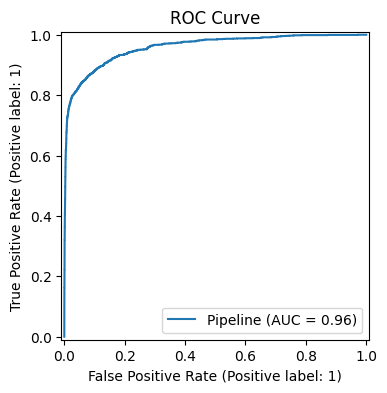

In [40]:
fig, ax = plt.subplots(figsize=(4, 4))
RocCurveDisplay.from_estimator(pipeline, X_val, y_val, ax=ax)
ax.set_title('ROC Curve')
plt.show()

## 10. Model Optimization

**At which point should we stop giving loans?**

We should stop giving loans away **the moment that our profit is lower than the loss of giving the loan**. In other words our goal is to minimize the profit sacrificed (FP) while maximizing the loss avoided (TP). At this point we are giving the loans the moment the probability of being a good loan is greater that 0.5. But this may not be the optimal point because the money we lose by giving a loan to a bad applicant is not the same as the money we win by giving a loan to a good applicant when we are 50% sure about our choice.

```plaintext
objective = Maximize(Amount of money we lose by TP - Amount of money we win by FP)

First we compute the probabilities of being correctly predicting a bad loan (true positive):

In [41]:
y_probs = pipeline.predict_proba(X_val)
y_tp_probs = y_probs[:, 1]  # 1 == bad loan

Then we compute the False Positives Ratio (FPR)  and the True Positives Ratio (TPR) for each threshold.

In [42]:
from sklearn.metrics import roc_curve

In [43]:
fpr, tpr, thresholds = roc_curve(y_val, y_tp_probs)

Finally we compute the optimal point by maximizing the objective function: maximizing the difference between the True Positives and the False Positives.

In [44]:
import numpy as np

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
fpr_optimal = fpr[optimal_idx]
tpr_optimal = tpr[optimal_idx]

print(f'Optimal threshold: {optimal_threshold:.4f}')
print(f'FPR: {fpr_optimal:.4f}')
print(f'TPR: {tpr_optimal:.4f}')

Optimal threshold: 0.1281
FPR: 0.0776
TPR: 0.8630


We compare the AUC when we use the threshold of 0.5 (default).

In [45]:
average_idx = len(thresholds) // 2
average_threshold = thresholds[average_idx]
fpr_average = fpr[average_idx]
tpr_average = tpr[average_idx]

print(f'Average threshold: {average_threshold:.4f}')
print(f'FPR: {fpr_average:.4f}')
print(f'TPR: {tpr_average:.4f}')

Average threshold: 0.0945
FPR: 0.1171
TPR: 0.8928


Plot the AUC for the optimal threshold and the default threshold.

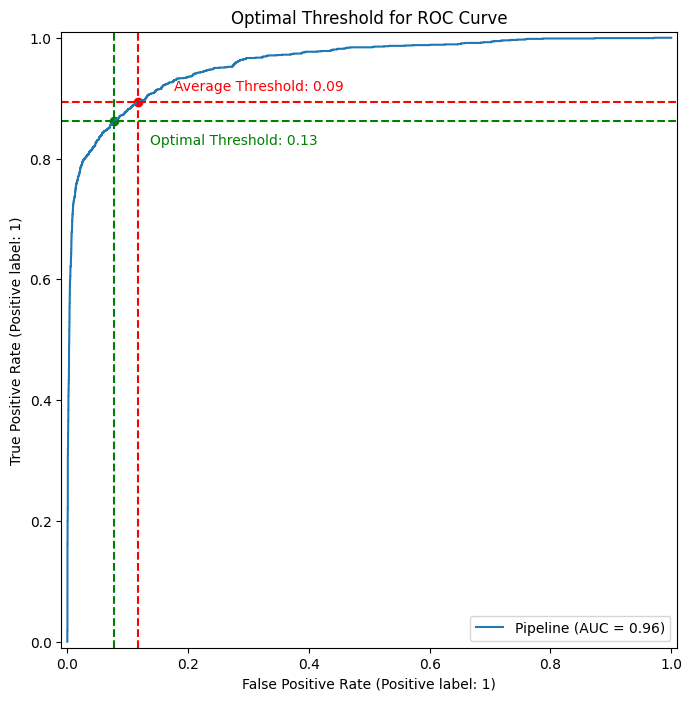

In [46]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_estimator(pipeline, X_val, y_val, ax=ax)
ax.set_title('Optimal Threshold for ROC Curve')

# shift the label using margins
x_margin = 0.06
y_margin = 0.02

# add optimal point coordinates
ax.axvline(fpr_optimal, color='g', linestyle='--')
ax.axhline(tpr_optimal, color='g', linestyle='--')
ax.scatter(fpr_optimal, tpr_optimal, color='green')  # Añadir el punto
ax.text(fpr_optimal + x_margin, tpr_optimal - y_margin * 2, f'Optimal Threshold: {optimal_threshold:.2f}', color='green')

# add average point coordinates
ax.axvline(fpr_average, color='r', linestyle='--')
ax.axhline(tpr_average, color='r', linestyle='--')
ax.scatter(fpr_average, tpr_average, color='red')  # Añadir el punto
ax.text(fpr_average + x_margin, tpr_average + y_margin, f'Average Threshold: {average_threshold:.2f}', color='red')

plt.show()

Add this tunning step to the pipeline.

In [47]:
from sklearn.model_selection import TunedThresholdClassifierCV

### Create the final tuned classifier model

In [48]:
model = TunedThresholdClassifierCV(pipeline, scoring="roc_auc")

Train the model again with the new pipeline.

In [49]:
model.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       StandardScaler(),
                                                                                       ['person_age',
                                                                                        'person_income',
                                                                                        'person_emp_length',
                                                                                        'loan_amnt',
                                                                                        'loan_int_rate',
                                                                                        'loan_percent_income',
                                                                                        'cb_person_cred_hist_length']),
                                                                                      ('cat',
                                                                                       OneHotEncoder(),
                                                                                       ['person_home_ownership',
                                                                                        'loan_intent',
                                                                                        'loan_grade',
                                                                                        'cb_person_default_...
                                                      LGBMClassifier(model__colsample_bytree=0.6119695976383072,
                                                                     model__lambda_l1=0.00232458444320226,
                                                                     model__lambda_l2=0.02255505210477446,
                                                                     model__learning_rate=0.04750301556798148,
                                                                     model__max_depth=5,
                                                                     model__min_child_samples=50,
                                                                     model__n_estimators=500,
                                                                     model__num_leaves=200,
                                                                     model__subsample=0.9599148308206902,
                                                                     random_state=42,
                                                                     verbosity=-1))]),
                           scoring='roc_auc')

Evaluate the model

In [50]:
y_pred = model.predict(X_val)
auc_metric = roc_auc_score(y_val, y_pred)

print(f'AUC: {auc_metric:.4f}')

AUC: 0.8915


In [51]:
import numpy as np
from sklearn.metrics import roc_curve


y_tp_probs = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_tp_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = model.best_threshold_
fpr_optimal = fpr[optimal_idx]
tpr_optimal = tpr[optimal_idx]

print(f'Optimal threshold: {optimal_threshold:.4f}')
print(f'FPR: {fpr_optimal:.4f}')
print(f'TPR: {tpr_optimal:.4f}')

Optimal threshold: 0.1315
FPR: 0.0776
TPR: 0.8630


Plot the ROC curve and the optimal threshold

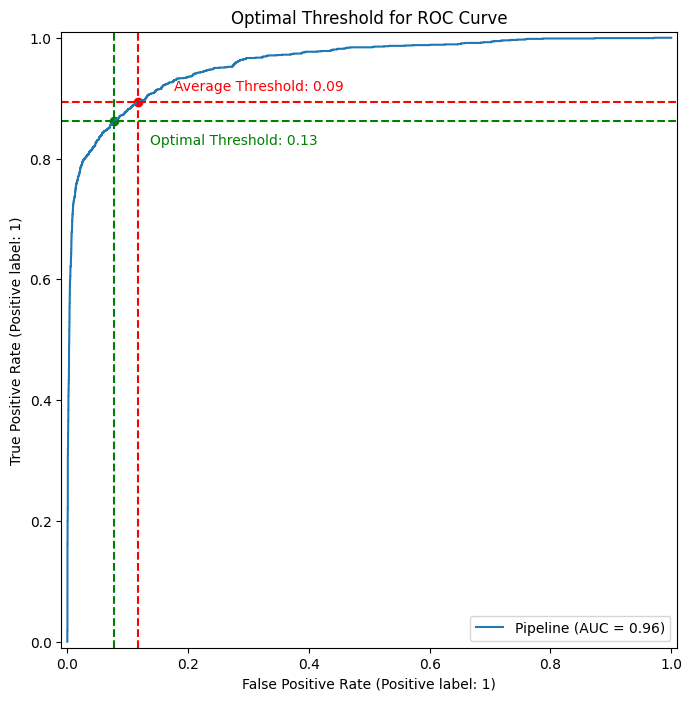

In [52]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

fig, ax = plt.subplots(figsize=(8, 8))
RocCurveDisplay.from_estimator(pipeline, X_val, y_val, ax=ax)
ax.set_title('Optimal Threshold for ROC Curve')

# shift the label using margins
x_margin = 0.06
y_margin = 0.02

# add optimal point coordinates
ax.axvline(fpr_optimal, color='g', linestyle='--')
ax.axhline(tpr_optimal, color='g', linestyle='--')
ax.scatter(fpr_optimal, tpr_optimal, color='green')  # Añadir el punto
ax.text(fpr_optimal + x_margin, tpr_optimal - y_margin * 2, f'Optimal Threshold: {optimal_threshold:.2f}', color='green')

# add average point coordinates
ax.axvline(fpr_average, color='r', linestyle='--')
ax.axhline(tpr_average, color='r', linestyle='--')
ax.scatter(fpr_average, tpr_average, color='red')  # Añadir el punto
ax.text(fpr_average + x_margin, tpr_average + y_margin, f'Average Threshold: {average_threshold:.2f}', color='red')

plt.show()

### Log the metrics

In [53]:
model_name = 'LGBMClassifier_threshold'
with mlflow.start_run(run_name=model_name):
           
    # Log the best parameters found using BayesSearch
    for param, value in best_parameters.items():
        mlflow.log_param(param, value)
    
    mlflow.log_param("model_type", model_name)

    # Train the model
    model = pipeline.fit(X_train, y_train)
            
    # make predictions
    y_val_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_val_pred)

    # log auc
    mlflow.log_metric("auc", auc)

    mlflow.set_tag("model", model.__class__.__name__)

    mlflow.log_metric("auc", auc_metric)
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("fpr_optimal", fpr_optimal)
    mlflow.log_metric("tpr_optimal", tpr_optimal)
    mlflow.log_metric("average_threshold", average_threshold)
    mlflow.log_metric("fpr_average", fpr_average)
    mlflow.log_metric("tpr_average", tpr_average)

    # Infer the signature of the model
    signature = infer_signature(X, y)

    mlflow.sklearn.log_model(model, "model", signature=signature)
    mlflow.log_artifact(SUBMISSION_CSV_PATH)
    
    # Infer the signature of the model
    signature = infer_signature(X, y)
    
    # Log the trained model
    mlflow.sklearn.log_model(model, artifact_path=model_name,
                                signature = signature)

    # Register the model in the Model Registry
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_name}"
    mlflow.register_model(model_uri, model_name)

Successfully registered model 'LGBMClassifier_threshold'.
2025/01/17 23:25:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMClassifier_threshold, version 1


🏃 View run LGBMClassifier_threshold at: http://localhost:5000/#/experiments/429015150349487003/runs/928c9dcf2e9644f79e0064d1cce76342
🧪 View experiment at: http://localhost:5000/#/experiments/429015150349487003


Created version '1' of model 'LGBMClassifier_threshold'.


## 11. Generate submission file

Looking at the `submission_sample.csv` file we see that it hmut have two columns: `id` and `loan_status`. The `id` column must have the same values as the test set and the `loan_status` column must have the predictions.

In [54]:
# Save the CSV to be submitted to a file
SUBMISSION_CSV_PATH = DATA_FOLDER + 'submission.csv'

# obtain the predictions
y_test_pred = model.predict(test_df)

# prepare the data to be submitted
ids_column = test_df.index
submission_data = {
    "id": ids_column,
    "loan_status": y_test_pred
}

# save it to a CSV file
submission_df = pd.DataFrame(submission_data)
submission_df.to_csv(SUBMISSION_CSV_PATH, index=False)
submission_df.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,0


## 12. Kaggle Submission


Finally we can submit the predictions to the kaggle platfrom. To do so we are going to retrieve the submission CSV from the best MLFlow run and submit it to the kaggle platform. You could upload the results manually by going to the kaggle website and clicking on `Submit Predictions`. You can then upload the file and submit it. Or you can use the kaggle API to submit the file:

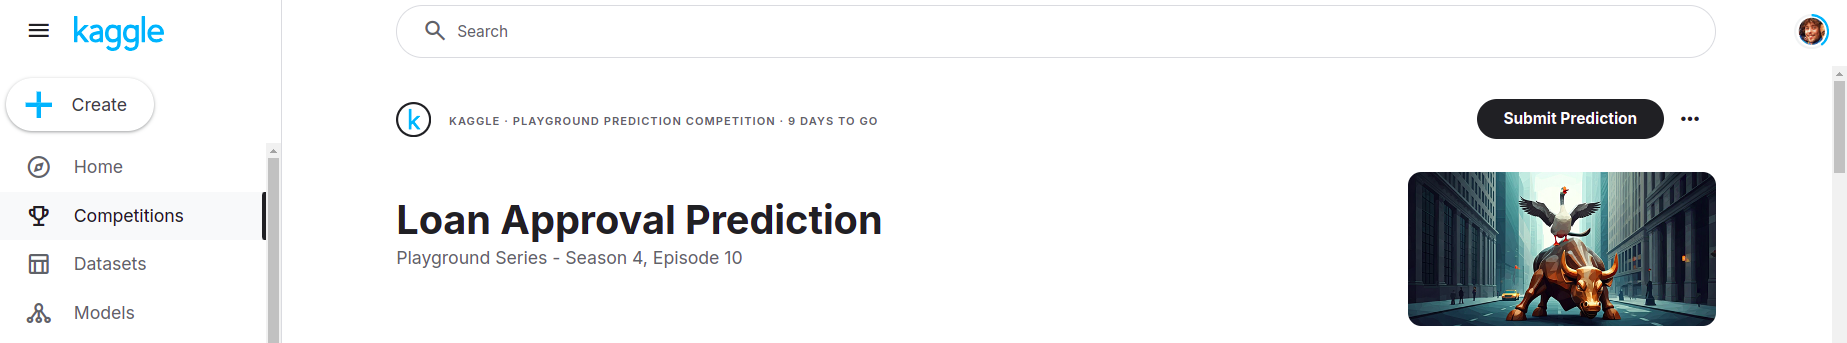

### 🎉 My Submission!:

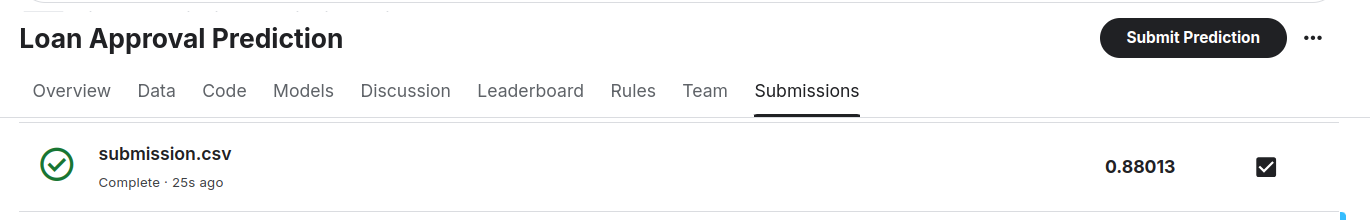

## 13. Deploy the model

⚠️⚠️ Important! Deploy the model using terminal ⚠️⚠️

```
mlflow models serve --model-uri models:/<model_name>@<version_alias>
```

<model_name> = LGBMClassifier_threshold
<version_alias> = production

```
mlflow models serve --model-uri models:/LGBMClassifier_threshold@production --host 127.0.0.1 --port 5001
``` 




### Check if the model is accepting requests

In [60]:
import requests

ENDPOINT = "http://localhost:5001/ping"

response = requests.get(ENDPOINT)
response

<Response [200]>

### Create URL for prediction requests

In [61]:
# Define the URL
ENDPOINT = 'http://localhost:5001/invocations'

### Preprocess the data to be sent

In [100]:
preprocessed_data = preprocessor.transform(test_df)

### Combine the preprocessed data into a dataframe

In [101]:
# Get column names for the transformed data
num_columns = num_features  # Column names for numeric features
cat_columns = preprocessor.transformers_[1][1].get_feature_names_out(cat_features)  # OneHotEncoder columns

# Combine column names
all_columns = list(num_columns) + list(cat_columns)

# Convert to DataFrame
preprocessed_df = pd.DataFrame(preprocessed_data, columns=all_columns)

In [102]:
preprocessed_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,-0.757007,0.130141,-0.436121,2.824250,1.688238,2.187295,-0.940719,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.259715,0.841503,0.339404,0.134238,0.668431,-0.650135,-0.449573,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.259715,-0.897382,0.080895,-0.941767,2.161719,-0.322739,-0.940719,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.900631,-0.370447,-0.177613,-0.403765,-0.583149,-0.213607,0.287147,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.259715,0.999584,0.856421,1.030908,1.873657,-0.104475,-0.449573,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Transform data into appropiate format
API requires data for the request in json format

In [115]:
import json

json_data = preprocessed_df.to_json(orient='records')
data = json.loads(json_data)

In [119]:
import json

json_data = test_df.to_json(orient='records')
data = json.loads(json_data)

In [120]:
# we build the body (payload) of the request
headers = {'Content-Type': 'application/json'}
# Extract features from the data
features = [list(row.values()) for row in data]  # list of lists (vectors)
body = {'inputs': features}

In [121]:
# Convert the payload to JSON format
body_json = json.dumps(body)

### Make a request

In [ ]:
# Make a POST request
response = requests.post(ENDPOINT, headers=headers, data=body_json)
print(response.json())

{'error_code': 'BAD_REQUEST', 'message': "Invalid input. invalid literal for int() with base 10: 'RENT'"}


👆🏼👆🏼 There's clearly an issue with the provided data in the request. Unfortunately, I don't have enough time to troubleshoot this error by now.